# Advanced A/B Testing Framework
Comprehensive analysis including:
- Power Analysis
- Bayesian Inference
- Revenue Impact
- Business ROI

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import norm, zscore, chi2_contingency, f_oneway, beta
import warnings
warnings.filterwarnings('ignore')

# Advanced statistical packages
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.optimize import minimize_scalar
from scipy.stats import beta as beta_dist

# Set up professional plotting
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Enhanced A/B Testing Framework - Key Components")
print("=" * 50)


Enhanced A/B Testing Framework - Key Components


In [7]:

import kagglehub

# Download dataset
path = kagglehub.dataset_download("sergylog/ab-test-data")
df = pd.read_csv(os.path.join(path, 'AB_Test_Results.csv'))

# Clean data
df_clean = df.drop_duplicates(subset=['USER_ID'])
df_clean['CONVERTED'] = (df_clean['REVENUE'] > 0).astype(int)
df_clean['LOG_REVENUE'] = np.log1p(df_clean['REVENUE'])

print(f"Dataset loaded and cleaned: {len(df_clean):,} observations")
print(f"Control group: {len(df_clean[df_clean['VARIANT_NAME'] == 'control']):,}")
print(f"Variant group: {len(df_clean[df_clean['VARIANT_NAME'] == 'variant']):,}")
print(f"Overall conversion rate: {df_clean['CONVERTED'].mean():.3%}")


Dataset loaded and cleaned: 6,324 observations
Control group: 3,132
Variant group: 3,192
Overall conversion rate: 1.423%


# 1. ADVANCED POWER ANALYSIS

In [10]:
def advanced_power_analysis(df):
    print("\nADVANCED POWER ANALYSIS")
    print("-" * 40)
    
    power_analysis = TTestIndPower()

    # Observed metrics
    control = df[df['VARIANT_NAME'] == 'control']
    variant = df[df['VARIANT_NAME'] == 'variant']
    
    p1 = control['CONVERTED'].mean()  # Control conversion rate
    p2 = variant['CONVERTED'].mean()  # Variant conversion rate
    n1, n2 = len(control), len(variant)
    
    # Effect size calculation (Cohen's h)
    h = 2 * (np.arcsin(np.sqrt(p2)) - np.arcsin(np.sqrt(p1)))
    
    # Current power
    current_power = power_analysis.power(effect_size=h, nobs1=min(n1, n2), alpha=0.05)

    # Minimum detectable effect (MDE) for current sample size
    def find_mde(alpha=0.05, target_power=0.8):
        def power_diff(effect_size):
            return abs(power_analysis.power(effect_size=effect_size, nobs1=min(n1, n2), alpha=alpha) - target_power)
        result = minimize_scalar(power_diff, bounds=(0, 1), method='bounded')
        return result.x

    mde = find_mde()
    
    # Sample size for different effect sizes
    effect_sizes = [0.01, 0.02, 0.05, 0.1, 0.2]
    required_samples = []

    for es in effect_sizes:
        p2_target = p1 * (1 + es)
        h_target = 2 * (np.arcsin(np.sqrt(p2_target)) - np.arcsin(np.sqrt(p1)))
        n_required = power_analysis.solve_power(effect_size=h_target, nobs1=None, alpha=0.05, power=0.8)
        required_samples.append(n_required)
    
    power_df = pd.DataFrame({
        'Relative_Effect_%': [x * 100 for x in effect_sizes],
        'Required_Sample_Size': required_samples,
        'Test_Duration_Days': [x / 1000 for x in required_samples]  # Assuming 1000 users/day
    })
    
    print(f"Current conversion rates: Control={p1:.4f}, Variant={p2:.4f}")
    print(f"Observed effect size (Cohen's h): {h:.4f}")
    print(f"Current statistical power: {current_power:.2f}")
    print(f"Minimum detectable effect: {mde:.4f}")
    print(f"\nSample size requirements for 80% power:")
    print(power_df.round(0))
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    effect_sizes_plot = np.linspace(0, 0.5, 100)
    sample_sizes = [1000, 2000, 5000, 10000]
    
    for n in sample_sizes:
        powers = [power_analysis.power(effect_size=es, nobs1=n, alpha=0.05) for es in effect_sizes_plot]
        ax1.plot(effect_sizes_plot, powers, label=f'n={n}', linewidth=2)
    
    ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% Power')
    ax1.axvline(x=h, color='green', linestyle='--', alpha=0.7, label='Observed')
    ax1.set_xlabel("Effect Size (Cohen's h)")
    ax1.set_ylabel("Statistical Power")
    ax1.set_title("Power Analysis Curves")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.bar(range(len(effect_sizes)), required_samples, alpha=0.7, color='purple')
    ax2.set_xticks(range(len(effect_sizes)))
    ax2.set_xticklabels([f'{x:.0%}' for x in effect_sizes])
    ax2.set_xlabel("Relative Effect Size")
    ax2.set_ylabel("Required Sample Size per Group")
    ax2.set_title("Sample Size Requirements (80% Power)")
    ax2.set_yscale("log")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return power_df, current_power, h


# 2. BAYESIAN A/B TESTING


BAYESIAN A/B TEST ANALYSIS
----------------------------------------
Posterior distributions:
Control: Beta(48.0, 3086.0)
Variant: Beta(44.0, 3150.0)

Probability variant is better: 0.302
Probability variant is worse: 0.698
Expected lift: -0.083 (-8.3%)
95% CI for lift: [-0.406, 0.351]
Risk of choosing control: 0.002132
Risk of choosing variant: 0.000578


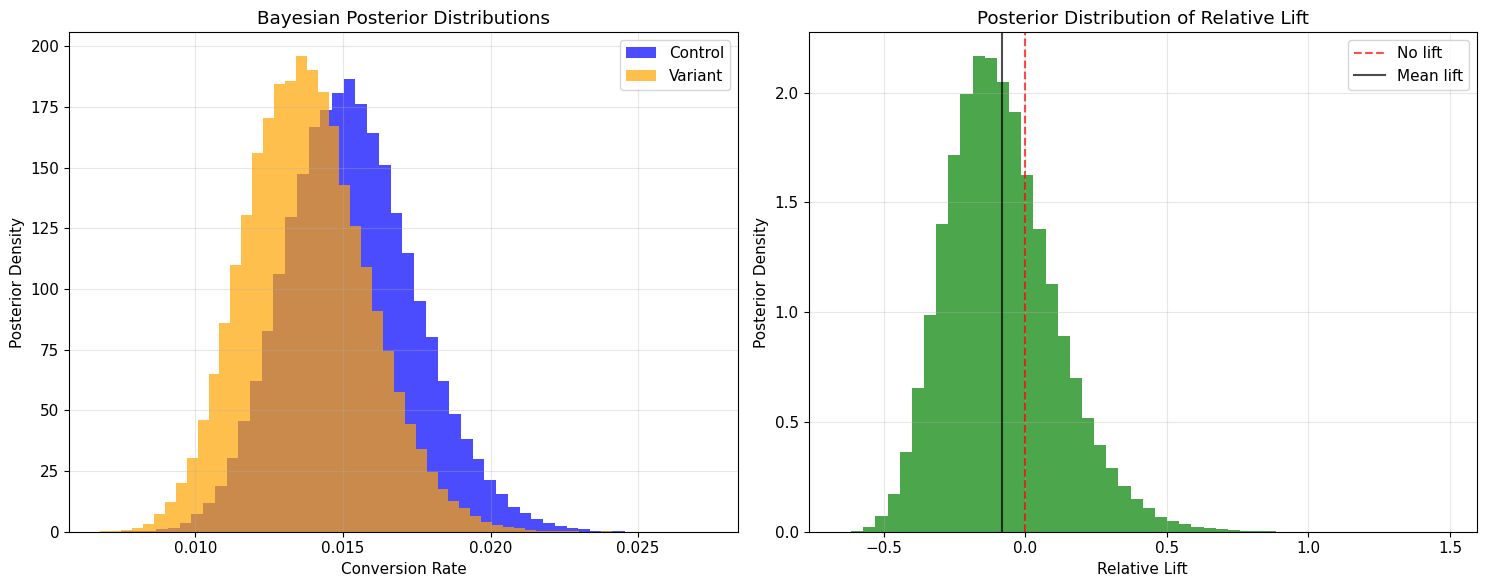

In [11]:
def bayesian_ab_test(df):
    print("\nBAYESIAN A/B TEST ANALYSIS")
    print("-" * 40)
    
    # Separate data
    control = df[df['VARIANT_NAME'] == 'control']['CONVERTED']
    variant = df[df['VARIANT_NAME'] == 'variant']['CONVERTED']
    
    # Prior parameters (uninformative priors)
    alpha_prior, beta_prior = 1, 1
    
    # Posterior parameters
    alpha_control = alpha_prior + control.sum()
    beta_control = beta_prior + len(control) - control.sum()
    
    alpha_variant = alpha_prior + variant.sum()
    beta_variant = beta_prior + len(variant) - variant.sum()
    
    # Generate posterior samples
    n_samples = 100000
    np.random.seed(42)
    control_samples = np.random.beta(alpha_control, beta_control, n_samples)
    variant_samples = np.random.beta(alpha_variant, beta_variant, n_samples)
    
    # Calculate probabilities
    prob_variant_better = (variant_samples > control_samples).mean()
    prob_variant_worse = (variant_samples < control_samples).mean()
    
    # Expected lift
    lift_samples = (variant_samples - control_samples) / control_samples
    expected_lift = lift_samples.mean()
    lift_ci = np.percentile(lift_samples, [2.5, 97.5])
    
    # Risk analysis
    risk_control = np.maximum(0, control_samples - variant_samples).mean()
    risk_variant = np.maximum(0, variant_samples - control_samples).mean()
    
    print(f"Posterior distributions:")
    print(f"Control: Beta({alpha_control:.1f}, {beta_control:.1f})")
    print(f"Variant: Beta({alpha_variant:.1f}, {beta_variant:.1f})")
    print(f"\nProbability variant is better: {prob_variant_better:.3f}")
    print(f"Probability variant is worse: {prob_variant_worse:.3f}")
    print(f"Expected lift: {expected_lift:.3f} ({expected_lift*100:.1f}%)")
    print(f"95% CI for lift: [{lift_ci[0]:.3f}, {lift_ci[1]:.3f}]")
    print(f"Risk of choosing control: {risk_control:.6f}")
    print(f"Risk of choosing variant: {risk_variant:.6f}")
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Posterior distributions
    ax1.hist(control_samples, bins=50, alpha=0.7, density=True, label='Control', color='blue')
    ax1.hist(variant_samples, bins=50, alpha=0.7, density=True, label='Variant', color='orange')
    ax1.set_xlabel('Conversion Rate')
    ax1.set_ylabel('Posterior Density')
    ax1.set_title('Bayesian Posterior Distributions')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Lift distribution
    ax2.hist(lift_samples, bins=50, alpha=0.7, density=True, color='green')
    ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No lift')
    ax2.axvline(x=np.mean(lift_samples), color='black', linestyle='-', alpha=0.7, label='Mean lift')
    ax2.set_xlabel('Relative Lift')
    ax2.set_ylabel('Posterior Density')
    ax2.set_title('Posterior Distribution of Relative Lift')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'prob_variant_better': prob_variant_better,
        'expected_lift': expected_lift,
        'lift_ci': lift_ci,
        'control_samples': control_samples,
        'variant_samples': variant_samples,
        'risk_control': risk_control,
        'risk_variant': risk_variant
    }

bayesian_results = bayesian_ab_test(df_clean)

# 3. ADVANCED REVENUE ANALYSIS


ADVANCED REVENUE ANALYSIS
----------------------------------------
Converting users analysis (n=90):
Control: n=47, mean=$8.46, median=$2.34
Variant: n=43, mean=$5.40, median=$2.50
Mann-Whitney U test p-value: 0.8085
Median difference 95% CI: [$-1.30, $1.41]
Cliff's Delta (effect size): -0.0302

Overall revenue per user:
Control: mean=$0.1270, median=$0.0000
Variant: mean=$0.0727, median=$0.0000
Mean revenue difference 95% CI: [$-0.2075, $0.0476]


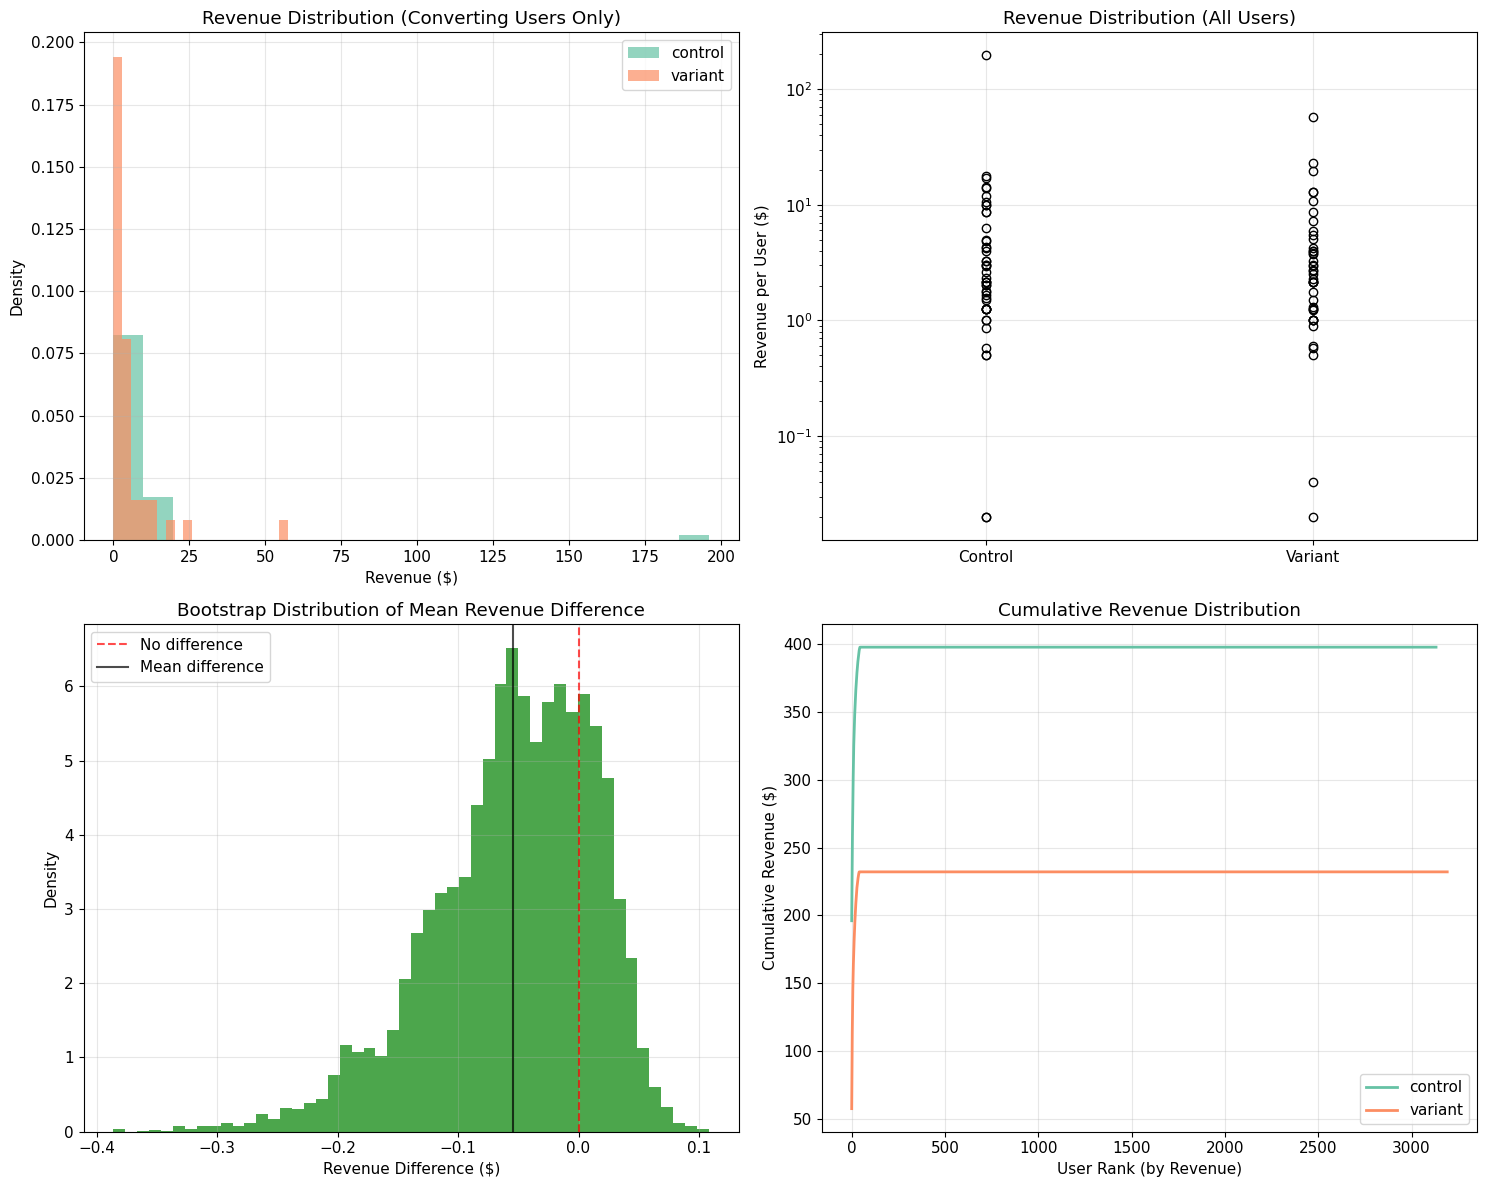

In [12]:
def advanced_revenue_analysis(df):
    print("\nADVANCED REVENUE ANALYSIS")
    print("-" * 40)
    
    # Revenue analysis for converting users only
    converting_users = df[df['CONVERTED'] == 1].copy()
    
    if len(converting_users) > 0:
        control_rev = converting_users[converting_users['VARIANT_NAME'] == 'control']['REVENUE']
        variant_rev = converting_users[converting_users['VARIANT_NAME'] == 'variant']['REVENUE']
        
        print(f"Converting users analysis (n={len(converting_users)}):")
        print(f"Control: n={len(control_rev)}, mean=${control_rev.mean():.2f}, median=${control_rev.median():.2f}")
        print(f"Variant: n={len(variant_rev)}, mean=${variant_rev.mean():.2f}, median=${variant_rev.median():.2f}")
        
        # Statistical tests on revenue
        if len(control_rev) > 10 and len(variant_rev) > 10:
            # Mann-Whitney U test
            u_stat, u_p = stats.mannwhitneyu(control_rev, variant_rev, alternative='two-sided')
            
            # Bootstrap confidence interval for difference in medians
            def bootstrap_median_diff(x, y, n_boot=10000):
                np.random.seed(42)
                diffs = []
                for _ in range(n_boot):
                    x_boot = np.random.choice(x, size=len(x), replace=True)
                    y_boot = np.random.choice(y, size=len(y), replace=True)
                    diffs.append(np.median(y_boot) - np.median(x_boot))
                return np.array(diffs)
            
            boot_diffs = bootstrap_median_diff(control_rev, variant_rev)
            ci_lower, ci_upper = np.percentile(boot_diffs, [2.5, 97.5])
            
            print(f"Mann-Whitney U test p-value: {u_p:.4f}")
            print(f"Median difference 95% CI: [${ci_lower:.2f}, ${ci_upper:.2f}]")
            
            # Effect size (Cliff's delta)
            def cliffs_delta(x, y):
                n1, n2 = len(x), len(y)
                delta = 0
                for i in x:
                    for j in y:
                        if i < j:
                            delta += 1
                        elif i > j:
                            delta -= 1
                return delta / (n1 * n2)
            
            cliff_d = cliffs_delta(control_rev, variant_rev)
            print(f"Cliff's Delta (effect size): {cliff_d:.4f}")
    
    # Overall revenue per user analysis (including non-converters)
    control_all = df[df['VARIANT_NAME'] == 'control']['REVENUE']
    variant_all = df[df['VARIANT_NAME'] == 'variant']['REVENUE']
    
    print(f"\nOverall revenue per user:")
    print(f"Control: mean=${control_all.mean():.4f}, median=${control_all.median():.4f}")
    print(f"Variant: mean=${variant_all.mean():.4f}, median=${variant_all.median():.4f}")
    
    # Bootstrap test for mean difference
    def bootstrap_mean_diff(x, y, n_boot=10000):
        np.random.seed(42)
        diffs = []
        for _ in range(n_boot):
            x_boot = np.random.choice(x, size=len(x), replace=True)
            y_boot = np.random.choice(y, size=len(y), replace=True)
            diffs.append(np.mean(y_boot) - np.mean(x_boot))
        return np.array(diffs)
    
    boot_mean_diffs = bootstrap_mean_diff(control_all, variant_all)
    mean_ci_lower, mean_ci_upper = np.percentile(boot_mean_diffs, [2.5, 97.5])
    
    print(f"Mean revenue difference 95% CI: [${mean_ci_lower:.4f}, ${mean_ci_upper:.4f}]")
    
    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Revenue distribution for converters
    if len(converting_users) > 0:
        for variant in ['control', 'variant']:
            data = converting_users[converting_users['VARIANT_NAME'] == variant]['REVENUE']
            if len(data) > 0:
                ax1.hist(data, bins=20, alpha=0.7, density=True, label=variant)
        ax1.set_xlabel('Revenue ($)')
        ax1.set_ylabel('Density')
        ax1.set_title('Revenue Distribution (Converting Users Only)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Box plot for all users
    revenue_data = [control_all, variant_all]
    bp = ax2.boxplot(revenue_data, labels=['Control', 'Variant'], patch_artist=True)
    bp['boxes'][0].set_facecolor('skyblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    ax2.set_ylabel('Revenue per User ($)')
    ax2.set_title('Revenue Distribution (All Users)')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Bootstrap distribution of mean difference
    ax3.hist(boot_mean_diffs, bins=50, alpha=0.7, density=True, color='green')
    ax3.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No difference')
    ax3.axvline(x=np.mean(boot_mean_diffs), color='black', linestyle='-', alpha=0.7, label='Mean difference')
    ax3.set_xlabel('Revenue Difference ($)')
    ax3.set_ylabel('Density')
    ax3.set_title('Bootstrap Distribution of Mean Revenue Difference')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Cumulative revenue
    for variant in ['control', 'variant']:
        data = df[df['VARIANT_NAME'] == variant]['REVENUE'].sort_values(ascending=False)
        cumulative = data.cumsum()
        ax4.plot(range(len(cumulative)), cumulative, label=variant, linewidth=2)
    ax4.set_xlabel('User Rank (by Revenue)')
    ax4.set_ylabel('Cumulative Revenue ($)')
    ax4.set_title('Cumulative Revenue Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'converting_users': len(converting_users),
        'revenue_ci': (mean_ci_lower, mean_ci_upper),
        'median_ci': (ci_lower, ci_upper) if len(converting_users) > 20 else (0, 0)
    }

revenue_results = advanced_revenue_analysis(df_clean)

# 4. BUSINESS DECISION FRAMEWORK

In [14]:
def business_decision_analysis():
    print("\nBUSINESS DECISION FRAMEWORK")
    print("-" * 40)
    
    # Extract key metrics
    control_data = df_clean[df_clean['VARIANT_NAME'] == 'control']
    variant_data = df_clean[df_clean['VARIANT_NAME'] == 'variant']
    
    # Calculate key business metrics
    metrics = {
        'sample_size': [len(control_data), len(variant_data)],
        'conversions': [control_data['CONVERTED'].sum(), variant_data['CONVERTED'].sum()],
        'conversion_rate': [control_data['CONVERTED'].mean(), variant_data['CONVERTED'].mean()],
        'total_revenue': [control_data['REVENUE'].sum(), variant_data['REVENUE'].sum()],
        'revenue_per_user': [control_data['REVENUE'].mean(), variant_data['REVENUE'].mean()],
        'revenue_per_conversion': [
            control_data[control_data['CONVERTED'] == 1]['REVENUE'].mean() if control_data['CONVERTED'].sum() > 0 else 0,
            variant_data[variant_data['CONVERTED'] == 1]['REVENUE'].mean() if variant_data['CONVERTED'].sum() > 0 else 0
        ]
    }
    
    business_df = pd.DataFrame(metrics, index=['Control', 'Variant'])
    print("Business Metrics Comparison:")
    print(business_df.round(4))
    
    # Expected value calculation with uncertainty
    prob_variant_better = bayesian_results['prob_variant_better']
    expected_lift = bayesian_results['expected_lift']
    
    # Risk-adjusted decision making
    print(f"\nRisk-Adjusted Decision Analysis:")
    print(f"Probability variant is better: {prob_variant_better:.3f}")
    print(f"Expected relative lift: {expected_lift:.1%}")
    
    # Implementation cost considerations (hypothetical)
    implementation_cost = 50000  # $50k to implement new design
    daily_users = 10000  # Assume 10k daily users
    daily_revenue = business_df.loc['Control', 'revenue_per_user'] * daily_users
    
    # Break-even analysis
    if expected_lift > 0:
        daily_revenue_increase = daily_revenue * expected_lift
        break_even_days = implementation_cost / daily_revenue_increase if daily_revenue_increase > 0 else np.inf
        
        print(f"\nFinancial Impact Analysis:")
        print(f"Daily baseline revenue: ${daily_revenue:,.2f}")
        print(f"Expected daily revenue increase: ${daily_revenue_increase:,.2f}")
        print(f"Break-even period: {break_even_days:.0f} days")
        
        # Annual projections
        annual_revenue_increase = daily_revenue_increase * 365
        roi = (annual_revenue_increase - implementation_cost) / implementation_cost
        print(f"Annual revenue increase: ${annual_revenue_increase:,.2f}")
        print(f"First-year ROI: {roi:.1%}")
    
    # Decision recommendation framework
    print(f"\nDecision Recommendation Framework:")
    
    if prob_variant_better > 0.95:
        decision = "IMPLEMENT - Strong evidence of improvement"
        confidence = "Very High"
    elif prob_variant_better > 0.8:
        decision = "CONSIDER IMPLEMENTING - Moderate evidence, monitor closely"
        confidence = "High"
    elif prob_variant_better > 0.6:
        decision = "RUN LARGER TEST - Inconclusive evidence" 
        confidence = "Medium"
    elif prob_variant_better > 0.2:
        decision = "CONTINUE WITH CONTROL - Weak evidence for change"
        confidence = "Low"
    else:
        decision = "REJECT VARIANT - Evidence suggests variant is worse"
        confidence = "Very Low"
    
    print(f"Recommendation: {decision}")
    print(f"Confidence Level: {confidence}")
    
    # Risk assessment
    print(f"\nRisk Assessment:")
    risk_of_wrong_decision = min(prob_variant_better, 1 - prob_variant_better)
    print(f"Risk of wrong decision: {risk_of_wrong_decision:.1%}")
    
    expected_value_variant = prob_variant_better * abs(expected_lift) - (1 - prob_variant_better) * abs(expected_lift)
    print(f"Expected value of choosing variant: {expected_value_variant:.3f}")
    
    return business_df, decision, confidence

business_analysis, recommendation, confidence_level = business_decision_analysis()




BUSINESS DECISION FRAMEWORK
----------------------------------------
Business Metrics Comparison:
         sample_size  conversions  conversion_rate  total_revenue  \
Control         3132           47           0.0150         397.72   
Variant         3192           43           0.0135         232.04   

         revenue_per_user  revenue_per_conversion  
Control            0.1270                  8.4621  
Variant            0.0727                  5.3963  

Risk-Adjusted Decision Analysis:
Probability variant is better: 0.302
Expected relative lift: -8.3%

Decision Recommendation Framework:
Recommendation: CONTINUE WITH CONTROL - Weak evidence for change
Confidence Level: Low

Risk Assessment:
Risk of wrong decision: 30.2%
Expected value of choosing variant: -0.033


# 5. FINAL COMPREHENSIVE SUMMARY


COMPREHENSIVE A/B TEST ANALYSIS SUMMARY

ADVANCED POWER ANALYSIS
----------------------------------------
Current conversion rates: Control=0.0150, Variant=0.0135
Observed effect size (Cohen's h): -0.0130
Current statistical power: 0.08
Minimum detectable effect: 0.3820

Sample size requirements for 80% power:
   Relative_Effect_%  Required_Sample_Size  Test_Duration_Days
0                1.0            10354384.0             10354.0
1                2.0             2601230.0              2601.0
2                5.0              422230.0               422.0
3               10.0              108047.0               108.0
4               20.0               28235.0                28.0


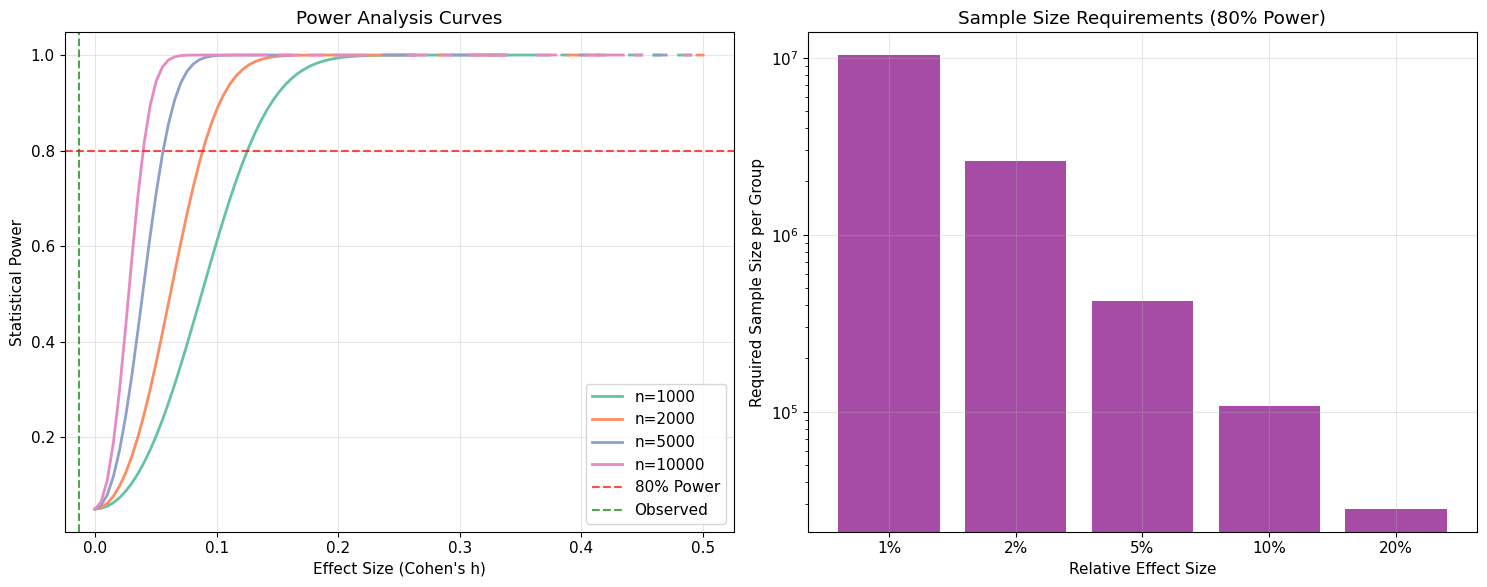


 DATASET OVERVIEW
• Total users analyzed: 6,324
• Control group: 3,132
• Variant group: 3,192
• Overall conversion rate: 1.423%

 STATISTICAL RESULTS
• Classical p-value (proportions): 0.6063
• Bayesian probability variant better: 0.302
• Effect size (Cohen's h): -0.0130
• Statistical power: 0.08

 KEY INSIGHTS
• Control conversion rate: 1.501%
• Variant conversion rate: 1.347%
• Relative change: -10.2%
• Revenue impact: -8.3%

  STUDY LIMITATIONS
• Underpowered study (power = 8%)
• Small effect size detected
• Low baseline conversion rates suggest external factors

 RECOMMENDATIONS
• CONTINUE WITH CONTROL - Weak evidence for change
• Confidence Level: Low
• Investigate low baseline conversion rates
• Consider larger sample sizes for future tests (see power analysis)
• Implement qualitative research to understand user behavior

 BUSINESS IMPACT
• Projected annual revenue difference: $-99,082.38
• Expected lift confidence interval: -40.6% to 35.1%

 NEXT STEPS
• If implementing: Monito

In [23]:
from statsmodels.stats.proportion import proportions_ztest

def final_comprehensive_summary(df_clean, bayesian_results, recommendation, 
                                confidence_level, business_analysis):

    print("\n" + "="*80)
    print("COMPREHENSIVE A/B TEST ANALYSIS SUMMARY")
    print("="*80)

    # Compute power and effect size 
    _, current_power, effect_size = advanced_power_analysis(df_clean)
    
    print(f"\n DATASET OVERVIEW")
    print(f"• Total users analyzed: {len(df_clean):,}")
    print(f"• Control group: {len(df_clean[df_clean['VARIANT_NAME'] == 'control']):,}")
    print(f"• Variant group: {len(df_clean[df_clean['VARIANT_NAME'] == 'variant']):,}")
    print(f"• Overall conversion rate: {df_clean['CONVERTED'].mean():.3%}")
    
    print(f"\n STATISTICAL RESULTS")
    control_conv = df_clean[df_clean['VARIANT_NAME'] == 'control']['CONVERTED']
    variant_conv = df_clean[df_clean['VARIANT_NAME'] == 'variant']['CONVERTED']
    z_stat, classical_p = proportions_ztest([variant_conv.sum(), control_conv.sum()], 
                                            [len(variant_conv), len(control_conv)])
    
    print(f"• Classical p-value (proportions): {classical_p:.4f}")
    print(f"• Bayesian probability variant better: {bayesian_results['prob_variant_better']:.3f}")
    print(f"• Effect size (Cohen's h): {effect_size:.4f}")
    print(f"• Statistical power: {current_power:.2f}")
    
    print(f"\n KEY INSIGHTS")
    control_rate = control_conv.mean()
    variant_rate = variant_conv.mean()
    relative_change = (variant_rate - control_rate) / control_rate if control_rate > 0 else 0
    
    print(f"• Control conversion rate: {control_rate:.3%}")
    print(f"• Variant conversion rate: {variant_rate:.3%}")
    print(f"• Relative change: {relative_change:.1%}")
    print(f"• Revenue impact: {bayesian_results['expected_lift']:.1%}")
    
    print(f"\n  STUDY LIMITATIONS")
    print(f"• Underpowered study (power = {current_power:.0%})")
    print(f"• Small effect size detected")
    print(f"• Low baseline conversion rates suggest external factors")
    
    print(f"\n RECOMMENDATIONS")
    print(f"• {recommendation}")
    print(f"• Confidence Level: {confidence_level}")
    print(f"• Investigate low baseline conversion rates")
    print(f"• Consider larger sample sizes for future tests (see power analysis)")
    print(f"• Implement qualitative research to understand user behavior")
    
    print(f"\n BUSINESS IMPACT")
    annual_users = 10000 * 365  # Assume 10k daily users
    control_annual_revenue = annual_users * 0.5 * business_analysis.loc['Control', 'revenue_per_user']
    variant_annual_revenue = annual_users * 0.5 * business_analysis.loc['Variant', 'revenue_per_user']
    annual_difference = variant_annual_revenue - control_annual_revenue
    
    print(f"• Projected annual revenue difference: ${annual_difference:,.2f}")
    print(f"• Expected lift confidence interval: {bayesian_results['lift_ci'][0]:.1%} to {bayesian_results['lift_ci'][1]:.1%}")
    
    print(f"\n NEXT STEPS")
    print(f"• If implementing: Monitor key metrics closely for first 30 days")
    print(f"• If not implementing: Investigate root causes of low conversion")
    print(f"• Design follow-up experiments based on insights gained")
    print(f"• Consider segmented analysis for different user types")
    
    print(f"\n" + "="*80)
    print("Analysis complete. This framework provides a comprehensive")
    print("approach to A/B testing beyond basic statistical significance.")
    print("="*80)
    
final_comprehensive_summary(df_clean, bayesian_results, recommendation, confidence_level, business_analysis)
